In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from datetime import datetime

# Keras
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, LSTM, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical


# MSE
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# データの分割
from sklearn.model_selection import train_test_split


# JupyterNotebook上でグラフを表示する設定
%matplotlib inline
# DataFrameで全ての列を表示する設定
pd.options.display.max_columns = None

In [4]:
train = pd.read_csv('train.csv')
train.head()

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0


In [73]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2026 non-null   object 
 1   Open    2026 non-null   float64
 2   High    2026 non-null   float64
 3   Low     2026 non-null   float64
 4   Close   2026 non-null   float64
 5   Up      2026 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 95.1+ KB


In [74]:
# Date(日付)のデータ型の変更  object型からdatetime64型に変更
train['Date'] = pd.to_datetime(train['Date'], format="%Y-%m-%d")
train.head()

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0


In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2026 non-null   datetime64[ns]
 1   Open    2026 non-null   float64       
 2   High    2026 non-null   float64       
 3   Low     2026 non-null   float64       
 4   Close   2026 non-null   float64       
 5   Up      2026 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 95.1 KB


In [76]:
# データの並び替え
train.sort_values(by='Date', ascending=True, inplace=True)
# インデックスの更新
train.set_index('Date', inplace=True)

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2026 entries, 2004-01-02 to 2012-01-18
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2026 non-null   float64
 1   High    2026 non-null   float64
 2   Low     2026 non-null   float64
 3   Close   2026 non-null   float64
 4   Up      2026 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 95.0 KB


In [78]:
train.head()

,Open,High,Low,Close,Up
Date,,,,,
2004-01-02,50.85,50.91,50.62,50.72,1
2004-01-05,50.75,50.84,50.61,50.79,1
2004-01-06,50.87,51.26,50.86,51.15,1
2004-01-07,51.45,51.54,51.29,51.51,0
2004-01-08,51.15,51.33,51.02,51.28,0


In [79]:
# [終値前日比] = ([当日終値] - [前日終値]) / [前日終値]を追加
# 終値前日比⇒Compared to the day before the closing price
# 略して、c_be_cl_price

# Closeの確認
print(train['Close'].head())

# 1列ずれてるか確認
print(train['Close'].shift(1).head())


train_rate = (train['Open'] - train['Close'].shift(1)) / train['Close'].shift(1)

# NaNを0に変換
train_rate = train_rate.fillna(0)
print(train_rate.head())

# 終値前日比の先頭5行の確認
# train['新たな行追加名'] = 追加する値
train['Rate'] = train_rate
print(train_rate.head())

# このtrainには新たに追加された値が反映されてる
print(train.head())

Date
2004-01-02    50.72
2004-01-05    50.79
2004-01-06    51.15
2004-01-07    51.51
2004-01-08    51.28
Name: Close, dtype: float64
Date
2004-01-02      NaN
2004-01-05    50.72
2004-01-06    50.79
2004-01-07    51.15
2004-01-08    51.51
Name: Close, dtype: float64
Date
2004-01-02    0.000000
2004-01-05    0.000591
2004-01-06    0.001575
2004-01-07    0.005865
2004-01-08   -0.006989
dtype: float64
Date
2004-01-02    0.000000
2004-01-05    0.000591
2004-01-06    0.001575
2004-01-07    0.005865
2004-01-08   -0.006989
dtype: float64
             Open   High    Low  Close  Up      Rate
Date                                                
2004-01-02  50.85  50.91  50.62  50.72   1  0.000000
2004-01-05  50.75  50.84  50.61  50.79   1  0.000591
2004-01-06  50.87  51.26  50.86  51.15   1  0.001575
2004-01-07  51.45  51.54  51.29  51.51   0  0.005865
2004-01-08  51.15  51.33  51.02  51.28   0 -0.006989


In [80]:
train.head()

,Open,High,Low,Close,Up,Rate
Date,,,,,,
2004-01-02,50.85,50.91,50.62,50.72,1,0.000000
2004-01-05,50.75,50.84,50.61,50.79,1,0.000591
2004-01-06,50.87,51.26,50.86,51.15,1,0.001575
2004-01-07,51.45,51.54,51.29,51.51,0,0.005865
2004-01-08,51.15,51.33,51.02,51.28,0,-0.006989


In [81]:
# closeを消去できるか確認
# train_2 = train.drop(columns=["Close"])
# train_2.head()

Text(0.5, 1.0, '2010-2012')

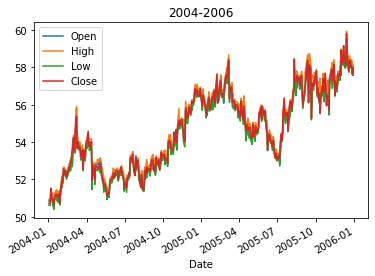

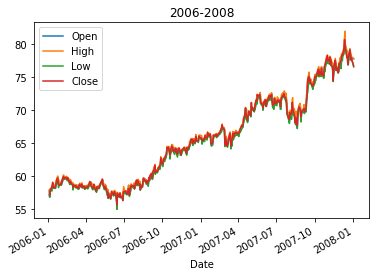

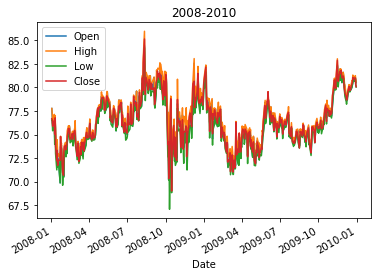

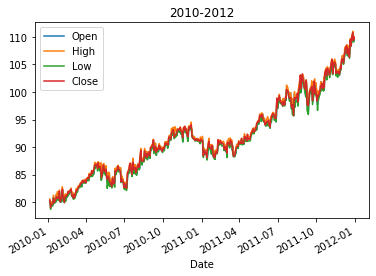

In [106]:
# 特定のカラムの抽出

train_plot = train[["Open", "High", "Low", "Close"]]

year1 = train_plot["2004-01-02":"2006-01-02"]
year1.plot(kind="line")
plt.title('2004-2006')

year2 = train_plot["2006-01-02":"2008-01-02"]
year2.plot(kind="line")
plt.title('2006-2008')

year3 = train_plot["2008-01-02":"2010-01-02"]
year3.plot(kind="line")
plt.title('2008-2010')

year4 = train_plot["2010-01-02":"2012-01-02"]
year4.plot(kind="line")
plt.title('2010-2012')

0    257
1    247
Name: Up, dtype: int64


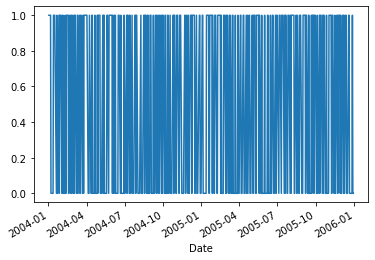

In [107]:
train_year1 = train.loc["2004-01-02":"2006-01-02"]
train_year1.head()

# データフレームからUpのみを抽出
Up = train_year1['Up']

# Upの出現数の確認
print(Up.value_counts())

# 株価の上昇回数の描画
Up.plot(kind="line")

# 描画の実行
plt.show()

In [84]:
# X⇒説明変数、Y⇒目的変数
X = train[["Open", "High", "Low", "Close", "Rate"]]
Y = train["Up"]

In [85]:
# 形状確認
print(X.shape)
print(Y.shape)

(2026, 5)
(2026,)


In [86]:
# カテゴリー変数への展開
from tensorflow.keras.utils import to_categorical

Y1 = to_categorical(Y)

In [87]:
# 形状の確認
print(Y1.shape)
print(X.shape)

(2026, 2)
(2026, 5)


In [88]:
# 今回はカテゴリー変数は使用しない

In [89]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [90]:
# 形状確認
print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_test:", X_test.shape, "Y_test:", Y_test.shape)
print("X_valid:", X_valid.shape, "Y_valid:", Y_valid.shape)

X_train: (850, 5) Y_train: (850,)
X_test: (811, 5) Y_test: (811,)
X_valid: (365, 5) Y_valid: (365,)


In [91]:
# 先頭1～5列、2～6列、3～7列と5日間事で未来値を予測。データを分散化することでより精度よく予測を行うことが出来る。


def get_standardized(X, n):
    X = np.array(X)
    X_t_list = []
    for i in range(len(X) - n + 1):
        X_t = X[i:i+n, :]
        scaler = StandardScaler()
        X_standardized = scaler.fit_transform(X_t)
        X_t_list.append(X_standardized)
    return np.array(X_t_list) # ここはリスト化したX_t_listを使用する

n = 5 # number_data⇒略でnと表示

X_train_t = get_standardized(X=X_train, n=n)
X_test_t = get_standardized(X=X_test, n=n)
X_valid_t = get_standardized(X=X_valid, n=n)

Y_train_t = Y_train[n-1 :]
Y_test_t = Y_test[n-1 :]
Y_valid_t = Y_valid[n-1 :]


In [92]:
# 形状確認
print("X_train_t:", X_train_t.shape, "Y_train_t:", Y_train_t.shape)
print("X_test_t:", X_test_t.shape, "Y_test_t:", Y_test_t.shape)
print("X_valid_t:", X_valid_t.shape, "Y_valid_t:", Y_valid_t.shape)

X_train_t: (846, 5, 5) Y_train_t: (846,)
X_test_t: (807, 5, 5) Y_test_t: (807,)
X_valid_t: (361, 5, 5) Y_valid_t: (361,)


In [93]:
# ネットワークの各層のサイズの定義
num_l1 = 100
num_l2 = 15
num_output = 1

# 以下、ネットワークを構築
model = Sequential()
# 第1層
model.add(LSTM(units=num_l1,
                activation='tanh',
                batch_input_shape=(None, X_train_t.shape[1], X_train_t.shape[2])))
# 第2層
model.add(Dense(num_l2, activation='relu'))
# 出力層
model.add(Dense(num_output, activation='sigmoid'))
# ネットワークのコンパイル
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# モデルの学習の実行（学習の完了までには数秒から数十秒ほど時間がかかります。）
log = model.fit(x=X_train_t, y=Y_train_t, epochs=80, batch_size=28, validation_data=(X_valid_t, Y_valid_t))


Epoch 1/80
31/31 [==============================] - 1s 31ms/step - loss: 0.6910 - accuracy: 0.5213 - val_loss: 0.6870 - val_accuracy: 0.5291
Epoch 2/80
31/31 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5650 - val_loss: 0.6860 - val_accuracy: 0.5623
Epoch 3/80
31/31 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5591 - val_loss: 0.6864 - val_accuracy: 0.5402
Epoch 4/80
31/31 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5827 - val_loss: 0.6835 - val_accuracy: 0.5457
Epoch 5/80
31/31 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.5898 - val_loss: 0.6819 - val_accuracy: 0.5402
Epoch 6/80
31/31 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.5922 - val_loss: 0.6825 - val_accuracy: 0.5319
Epoch 7/80
31/31 [==============================] - 0s 4ms/step - loss: 0.6735 - accuracy: 0.5851 - val_loss: 0.6774 - val_accuracy: 0.5512
Epoch 8/80
31/31 [=

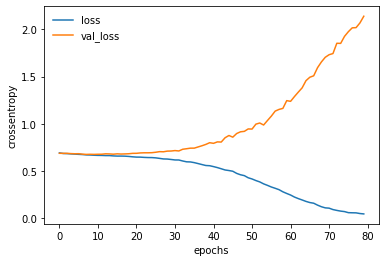

In [94]:
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

In [95]:
Y_pred = model.predict(X_test_t)


In [96]:
Y_test_t

Date
2008-10-08    1
2004-08-05    0
2007-09-10    1
2004-11-30    1
2009-01-15    1
             ..
2007-11-28    0
2009-05-29    1
2011-03-29    1
2010-12-23    0
2008-12-12    1
Name: Up, Length: 807, dtype: int64

In [97]:
loss, accuracy = model.evaluate(X_test_t, Y_test_t)

# 評価データの正解率の表示
print('評価データの正解率:', accuracy)

26/26 [==============================] - 0s 1ms/step - loss: 2.3902 - accuracy: 0.4969
評価データの正解率: 0.49690210819244385


In [99]:
# Dropoutのインポート
from keras.layers import Dropout

# ネットワークの各層のサイズの定義
num_l1 = 100
num_l2 = 20
num_output = 1

# Dropoutの割合の定義
dropout_rate = 0.4

# 以下、ネットワークを構築
model = Sequential()
# 第1層
model.add(LSTM(units=num_l1, 
               activation='tanh', 
               batch_input_shape=(None, X_train_t.shape[1], X_train_t.shape[2])))
model.add(Dropout(dropout_rate))
# 第2層
model.add(Dense(num_l2, activation='relu'))
model.add(Dropout(dropout_rate))
# 出力層
model.add(Dense(num_output, activation='sigmoid'))
# ネットワークのコンパイル
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# モデルの学習の実行（学習の完了までには数秒から数十秒ほど時間がかかります。）
log = model.fit(x=X_train_t, y=Y_train_t, epochs=80, batch_size=24, validation_data=(X_valid_t, Y_valid_t))


Epoch 1/80
36/36 [==============================] - 1s 18ms/step - loss: 0.6932 - accuracy: 0.5071 - val_loss: 0.6889 - val_accuracy: 0.5208
Epoch 2/80
36/36 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5461 - val_loss: 0.6856 - val_accuracy: 0.5374
Epoch 3/80
36/36 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.5697 - val_loss: 0.6838 - val_accuracy: 0.5402
Epoch 4/80
36/36 [==============================] - 0s 4ms/step - loss: 0.6805 - accuracy: 0.5733 - val_loss: 0.6834 - val_accuracy: 0.5402
Epoch 5/80
36/36 [==============================] - 0s 4ms/step - loss: 0.6803 - accuracy: 0.5780 - val_loss: 0.6817 - val_accuracy: 0.5402
Epoch 6/80
36/36 [==============================] - 0s 4ms/step - loss: 0.6711 - accuracy: 0.5898 - val_loss: 0.6778 - val_accuracy: 0.5374
Epoch 7/80
36/36 [==============================] - 0s 4ms/step - loss: 0.6675 - accuracy: 0.6064 - val_loss: 0.6765 - val_accuracy: 0.5402
Epoch 8/80
36/36 [=

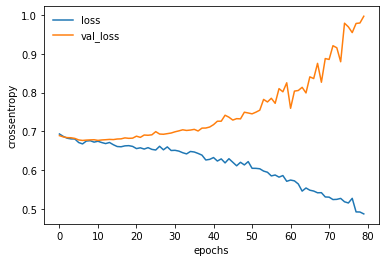

In [102]:
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False)
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

In [103]:
from sklearn.metrics import accuracy_score

# 評価データの予測結果の算出
pred_prob = model.predict(X_test_t)

# 予測結果の先頭10件を確認
print('予測結果の先頭10件')
print(pred_prob[:10])

# 評価データの予測結果を0もしくは1に丸め込み
pred = np.round(pred_prob)

# 丸め込んだ予測結果の先頭10件を確認
print('丸め込んだ予測結果の先頭10件')
print(pred[:10])

# 評価データの正解率の計算
accuracy = accuracy_score(y_true=Y_test_t, y_pred=pred)

# 評価データの正解率の表示
print('評価データの正解率:', accuracy)

予測結果の先頭10件
[[0.48689282]
 [0.03897387]
 [0.07621431]
 [0.02888426]
 [0.5375832 ]
 [0.57755876]
 [0.89143896]
 [0.7047397 ]
 [0.67384434]
 [0.673337  ]]
丸め込んだ予測結果の先頭10件
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
評価データの正解率: 0.5241635687732342


予測時に、LSTM及びDropout追加し行ったが、両方とも過学習を起こしてしまった。
次回、前日と比較して株価が上昇 or 下降の2択ではなく、前日と比較して0～3%上昇 or 下降、3%以上上昇 or 下降と
4択程増やし、再度予測検証を行う